In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import random
import wandb
import matplotlib.pyplot as plt

# wandb.init(project="fish4", entity="junta")

class FishDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Populate image paths and labels
        for cluster_id in os.listdir(image_folder):
            cluster_path = os.path.join(image_folder, cluster_id)
            if os.path.isdir(cluster_path):
                # Extract the numeric part from the cluster_id (e.g., 'fish_14' -> 14)
                numeric_label = int(cluster_id.split('_')[1])
                for img_name in os.listdir(cluster_path):
                    img_path = os.path.join(cluster_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(numeric_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


class SiameseFishDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        # Extract labels
        self.labels = [label for _, label in self.dataset]
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: [] for label in self.labels_set}
        for idx, label in enumerate(self.labels):
            self.label_to_indices[label].append(idx)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img1, label1 = self.dataset[idx]
        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            idx2 = idx
            while idx2 == idx:
                idx2 = random.choice(self.label_to_indices[label1])
        else:
            label2 = random.choice([label for label in self.labels_set if label != label1])
            idx2 = random.choice(self.label_to_indices[label2])
        img2, label2 = self.dataset[idx2]
        label = int(label1 != label2)
        return img1, img2, label, label1, label2

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Normalize using ImageNet mean and std if using pre-trained model
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load the dataset
image_folder = 'fish_image'  # Replace with your dataset path
fish_dataset = FishDataset(image_folder=image_folder, transform=transform)

# Split indices for training and testing
train_indices, test_indices = train_test_split(
    list(range(len(fish_dataset))),
    test_size=0.2,
    stratify=fish_dataset.labels,
    random_state=42
)

# Create subsets
train_subset = Subset(fish_dataset, train_indices)
test_subset = Subset(fish_dataset, test_indices)

# Create Siamese datasets
train_siamese_dataset = SiameseFishDataset(train_subset)
test_siamese_dataset = SiameseFishDataset(test_subset)

# Create data loaders
train_loader = DataLoader(train_siamese_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_siamese_dataset, batch_size=32, shuffle=False)


In [ ]:
import numpy as np

# Initialize a matrix to store counts
num_classes = len(train_siamese_dataset.labels_set)
pairwise_counts = np.zeros((num_classes, num_classes), dtype=int)

for i in range(len(train_loader.dataset)):
    _, _, _, label1, label2 = train_loader.dataset[i]
    pairwise_counts[label1-1][label2-1] += 1

# Plotting the heatmap
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_counts, annot=False, cmap='Blues')
plt.xlabel('Label 2')
plt.ylabel('Label 1')
plt.title('Pairwise Class Combination Counts')
plt.show()


In [ ]:
similar_count = 0
dissimilar_count = 0

for i in range(len(train_loader.dataset)):
    _, _, label, _, _ = train_loader.dataset[i]
    if label == 0:
        similar_count += 1
    else:
        dissimilar_count += 1

print(f"Number of Similar Pairs: {similar_count}")
print(f"Number of Dissimilar Pairs: {dissimilar_count}")


In [ ]:
import os
from collections import Counter

def visualize_species_distribution(image_folder):
    # Dictionary to count images per species
    species_count = Counter()

    # Iterate through the folders (each folder represents a species)
    for species_folder in os.listdir(image_folder):
        species_path = os.path.join(image_folder, species_folder)
        if os.path.isdir(species_path):
            num_images = len(os.listdir(species_path))
            species_count[species_folder] = num_images

    # Sort species by name
    species_names = sorted(species_count.keys())
    counts = [species_count[name] for name in species_names]

    # Create a bar plot
    plt.figure(figsize=(15, 5))
    plt.bar(species_names, counts, color='skyblue')
    plt.xlabel("Fish Species")
    plt.ylabel("Number of Images")
    plt.title("Distribution of Fish Species in the Dataset")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


visualize_species_distribution(image_folder)


In [ ]:
import matplotlib.pyplot as plt
import random

def show_random_images_from_loader(data_loader, num_pairs=5):
    # Set up a figure to display the image pairs side-by-side
    fig, axes = plt.subplots(2, num_pairs, figsize=(num_pairs * 3, 6))

    # Get a batch of images from the data loader
    pairs_shown = 0
    for img1, img2, label, _, _ in data_loader:
        # Shuffle the images in the batch to show random samples
        indices = list(range(len(label)))
        random.shuffle(indices)

        for i in indices[:num_pairs]:
            if pairs_shown >= num_pairs:
                break

            # Convert images to CPU for visualization
            img1_np = img1[i].cpu().permute(1, 2, 0).numpy()
            img2_np = img2[i].cpu().permute(1, 2, 0).numpy()

            # Normalize the images for display
            img1_np = (img1_np - img1_np.min()) / (img1_np.max() - img1_np.min())
            img2_np = (img2_np - img2_np.min()) / (img2_np.max() - img2_np.min())

            # Plot Image 1 on the top row
            axes[0, pairs_shown].imshow(img1_np)
            axes[0, pairs_shown].axis('off')
            label_text = "Similar" if label[i].item() == 0 else "Dissimilar"
            axes[0, pairs_shown].set_title(f"Label: {label_text}", fontsize=15)

            # Plot Image 2 on the bottom row
            axes[1, pairs_shown].imshow(img2_np)
            axes[1, pairs_shown].axis('off')

            pairs_shown += 1

        if pairs_shown >= num_pairs:
            break

    plt.tight_layout()
    plt.show()

# Call the function to display random images from the train_loader
show_random_images_from_loader(train_loader, num_pairs=5)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Using a pre-trained model as the base network
        self.cnn = models.resnet18(weights="ResNet18_Weights.DEFAULT")
        # Modify the last layer
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 512)

    def forward_once(self, x):
        output = self.cnn(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [3]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(
                torch.clamp(self.margin - euclidean_distance, min=0.0), 2
            )
        )
        return loss_contrastive


In [4]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score


# Initialize network, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model

SiameseNetwork(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Use tqdm for the training loop
    for i, (img1, img2, label, _, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")):
        img1, img2, label = img1.to(device), img2.to(device), label.to(device).float()
        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on the test set
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_distances = []

    with torch.inference_mode():
        for img1, img2, label, _, _ in tqdm(test_loader, desc="Validation"):
            img1, img2, label = img1.to(device), img2.to(device).float(), label.to(device).float()
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            val_loss += loss.item()

            # Calculate Euclidean distance
            euclidean_distance = F.pairwise_distance(output1, output2)
            all_distances.extend(euclidean_distance.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    # Calculate metrics
    # Use a threshold of 1.0 for binary classification
    threshold = 1.0
    predictions = [1 if dist > threshold else 0 for dist in all_distances]
    test_accuracy = accuracy_score(all_labels, predictions) * 100
    roc_score = roc_auc_score(all_labels, all_distances)

    print(f"Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(test_loader):.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}, ROC Score: {roc_score:.4f}")

    torch.save(model.state_dict(), f"01/siamese-random-{epoch+1}.pt")

    # Log metrics to wandb
    wandb.log({
        "training_loss": running_loss / len(train_loader),
        "validation_loss": val_loss / len(test_loader),
        "test_accuracy": test_accuracy,
        "roc_score": roc_score
    })

# Finish wandb run
wandb.finish()


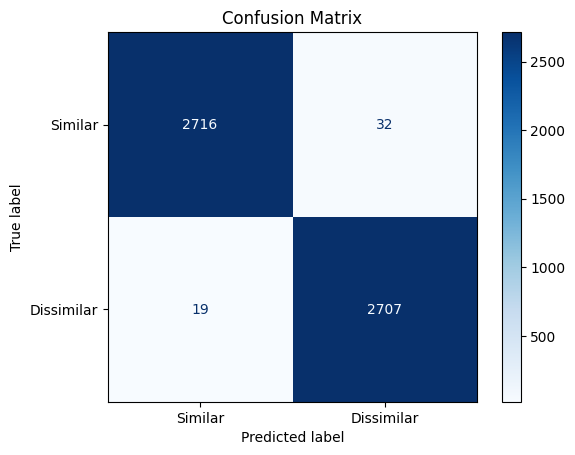

In [6]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.load_state_dict(
    torch.load("models/siamese-random-20.pt", map_location="cpu", weights_only=True)
)
model.eval()

def plot_confusion_matrix(model, data_loader, device, threshold=1.0):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.inference_mode():
        for img1, img2, label, _, _ in data_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device).float()
            # Get the outputs from the model
            output1, output2 = model(img1, img2)
            euclidean_distance = F.pairwise_distance(output1, output2)
            # Make predictions based on the threshold
            predictions = (euclidean_distance > threshold).float()
            # Collect all labels and predictions
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Similar", "Dissimilar"])
    
    # Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(model, test_loader, device)


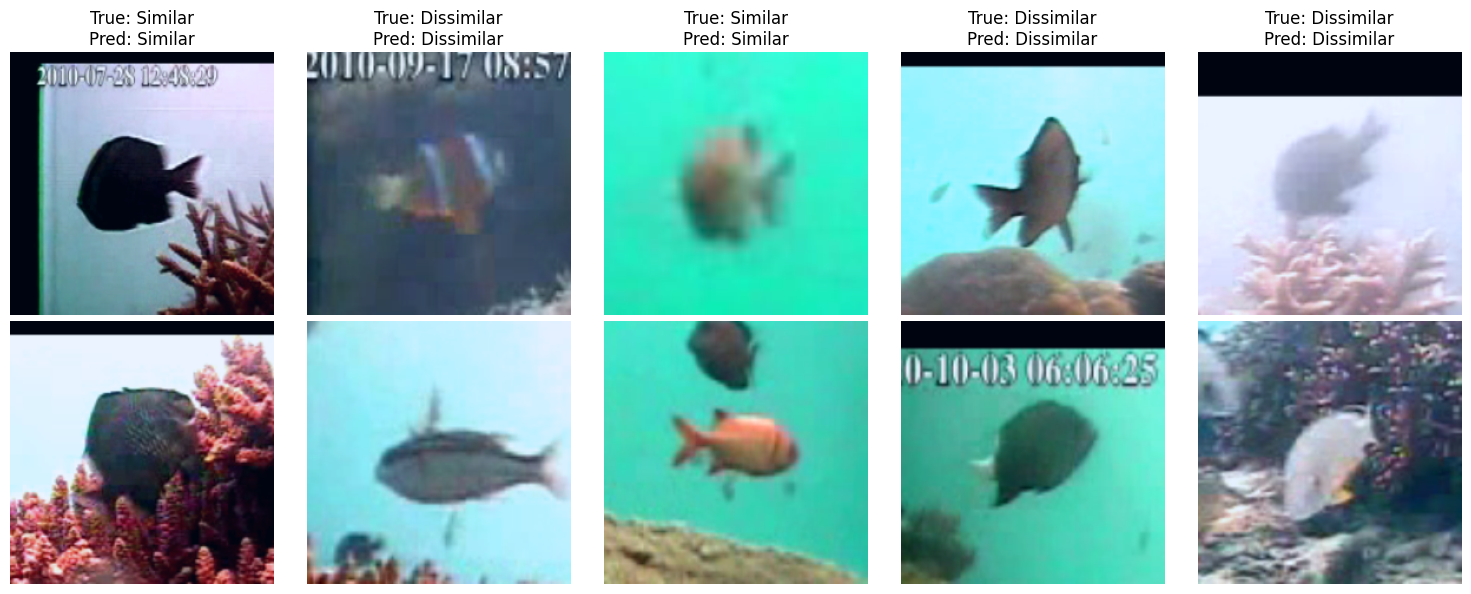

In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

def show_predictions_from_test_loader(model, data_loader, device, num_pairs=5, threshold=1.0):

    # Set up a figure to display the image pairs side-by-side
    fig, axes = plt.subplots(2, num_pairs, figsize=(num_pairs * 3, 6))

    pairs_shown = 0
    with torch.inference_mode():  # No need to compute gradients
        for img1, img2, label, _, _ in data_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device).float()

            # Get the outputs from the model
            output1, output2 = model(img1, img2)
            euclidean_distance = F.pairwise_distance(output1, output2)

            # Make predictions based on the threshold
            predictions = (euclidean_distance > threshold).float()

            # Shuffle the images in the batch to show random samples
            indices = list(range(len(label)))
            random.shuffle(indices)

            for i in indices[:num_pairs]:
                if pairs_shown >= num_pairs:
                    break

                # Convert images to CPU for visualization
                img1_np = img1[i].cpu().permute(1, 2, 0).numpy()
                img2_np = img2[i].cpu().permute(1, 2, 0).numpy()

                # Normalize the images for display
                img1_np = (img1_np - img1_np.min()) / (img1_np.max() - img1_np.min())
                img2_np = (img2_np - img2_np.min()) / (img2_np.max() - img2_np.min())

                # Plot Image 1 on the top row
                axes[0, pairs_shown].imshow(img1_np)
                axes[0, pairs_shown].axis('off')

                # True label and prediction
                true_label = "Similar" if label[i].item() == 0 else "Dissimilar"
                pred_label = "Similar" if predictions[i].item() == 0 else "Dissimilar"
                axes[0, pairs_shown].set_title(f"True: {true_label}\nPred: {pred_label}")

                # Plot Image 2 on the bottom row
                axes[1, pairs_shown].imshow(img2_np)
                axes[1, pairs_shown].axis('off')

                pairs_shown += 1

            if pairs_shown >= num_pairs:
                break

    plt.tight_layout()
    plt.show()

# Call the function to display random images from the test_loader
show_predictions_from_test_loader(model, test_loader, device, num_pairs=5)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
from PIL import Image

# Load the ImageFolder Dataset
image_folder = datasets.ImageFolder(root="fish_image")
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


# Define the Embedding Dataset Class
class EmbeddingDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = self.image_folder.imgs

    def __getitem__(self, index):
        img_path, label = self.image_paths[index]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.image_paths)


embedding_dataset = EmbeddingDataset(image_folder, transform=transform)
embedding_loader = DataLoader(embedding_dataset, batch_size=32, num_workers=4)

model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for images, targets in embedding_loader:
        images = images.to(device)
        outputs = model.forward_once(
            images
        )  # Forward pass through Siamese model to get embeddings
        embeddings.append(outputs.cpu())
        labels.append(targets)

embeddings = torch.cat(embeddings)
labels = torch.cat(labels)

# Split the Embeddings into Training and Testing Sets (80% Train, 20% Test)
train_size = int(0.8 * len(embeddings))
test_size = len(embeddings) - train_size
train_embeddings, test_embeddings = torch.utils.data.random_split(
    TensorDataset(embeddings, labels), [train_size, test_size]
)

# Create DataLoaders for Training and Testing
train_loader = DataLoader(train_embeddings, batch_size=32, shuffle=True)
test_loader = DataLoader(test_embeddings, batch_size=32, shuffle=False)


# Define the Embedding Classifier
class EmbeddingClassifier(nn.Module):
    def __init__(self, input_dim=512, num_classes=23):
        super(EmbeddingClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)


# Initialize the Classifier, Loss, and Optimizer
classifier = EmbeddingClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.0001)

# Training Loop with Accuracy Calculation
num_epochs = 100

wandb.init(project="fish4", entity="junta")

for epoch in range(num_epochs):
    classifier.train()
    total_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = classifier(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train_predictions += (predicted == targets).sum().item()
        total_train_samples += targets.size(0)

    train_accuracy = correct_train_predictions / total_train_samples * 100
    print(
        f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}"
    )

    # Evaluate on the Test Set
    classifier.eval()
    correct_test_predictions = 0
    total_test_samples = 0
    test_loss = 0  # Initialize the test loss
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = classifier(inputs)
            loss = criterion(outputs, targets)  # Calculate the loss
            test_loss += loss.item()  # Accumulate the test loss

            _, predicted = torch.max(outputs, 1)
            correct_test_predictions += (predicted == targets).sum().item()
            total_test_samples += targets.size(0)

    test_accuracy = correct_test_predictions / total_test_samples * 100
    average_test_loss = test_loss / len(test_loader)  # Calculate the average test loss

    print(f"Test Accuracy: {test_accuracy:.2f}")
    print(f"Test Loss: {average_test_loss:.4f}")

    wandb.log(
        {
            "training_loss": total_loss / len(train_loader),
            "validation_loss": average_test_loss,  # Log the test loss here
            "test_accuracy": test_accuracy,
        }
    )

    
wandb.finish()

In [ ]:
torch.save(model.state_dict(), f"01/siamese-random-embeded.pt")